In [1]:
import pandas as pd
import requests
import time

In [2]:
df = pd.read_csv('spotify_history.csv', sep=";", low_memory=False)

In [3]:
print(df.columns.tolist())

['Unnamed: 0', 'ts', 'username', 'platform', 'ms_played', 'conn_country', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode']


In [4]:
df = df.drop(columns=['Unnamed: 0', 'spotify_episode_uri', 'episode_name', 'episode_show_name'], axis=1)

In [5]:
print(df.columns.tolist())

['ts', 'username', 'platform', 'ms_played', 'conn_country', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name', 'spotify_track_uri', 'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode']


In [6]:
client_id = ''
client_secret = ''

In [7]:
# Step 1: Get access token
def get_access_token():
    auth_response = requests.post('https://accounts.spotify.com/api/token', {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })

    if auth_response.status_code != 200:
        raise Exception("Failed to authenticate with Spotify API")

    return auth_response.json()['access_token']

access_token = get_access_token()

In [6]:
# Step 2: Get genres for a given track and artist
def get_genres(track_name, artist_name, token):
    headers = {'Authorization': f'Bearer {token}'}
    query = f'track:{track_name} artist:{artist_name}'
    url = f"https://api.spotify.com/v1/search?q={requests.utils.quote(query)}&type=track&limit=1"
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        return None

    results = response.json()
    items = results.get('tracks', {}).get('items', [])
    if not items:
        return None

    artist_id = items[0]['artists'][0]['id']
    artist_url = f"https://api.spotify.com/v1/artists/{artist_id}"
    artist_response = requests.get(artist_url, headers=headers)

    if artist_response.status_code != 200:
        return None

    genres = artist_response.json().get('genres', [])
    return ', '.join(genres) if genres else None



In [50]:
# Step 3: Apply the genre fetching logic
genres = []
for index, row in df.iterrows():
    track = row['master_metadata_track_name']
    artist = row['master_metadata_album_artist_name']
    
    if pd.isna(track) or pd.isna(artist):
        genres.append(None)
        continue
    
    genre = get_genres(track, artist, access_token)
    genres.append(genre)
    
    print(f"{index + 1}/{len(df)}: {track} by {artist} --> {genre}")
    
    # To avoid hitting rate limits
    time.sleep(0.5)

# Step 4: Add genre column and save
df['genre'] = genres
df.to_csv("spotify_with_genres.csv", index=False)
print("✅ CSV updated with genre information!")


1/267493: International Love (feat. Chris Brown) by Pitbull --> None
2/267493: International Love (feat. Chris Brown) by Pitbull --> None
3/267493: Think About The Way - Single Edit by Groove Coverage --> eurodance
4/267493: Boys of Summer - Video Edit by Ole Van Dansk --> None
5/267493: Getting High by Devin The Dude --> southern hip hop, g-funk
6/267493: Broken by Evil Activities --> hardcore, gabber, hardstyle, frenchcore, hardcore techno, happy hardcore, speedcore
7/267493: Unafraid by Promo --> gabber, hardcore, frenchcore, hardcore techno, speedcore, happy hardcore, hardstyle
8/267493: I Enjoy Chaos by The Wishmaster --> hardcore, gabber, hardcore techno, frenchcore, speedcore, hardstyle
9/267493: Makebeliever by Nitrogenetics --> hardcore, gabber, hardcore techno, frenchcore, speedcore
10/267493: You Are Evil by Richie Gee --> hard techno, frenchcore, gabber, speedcore, hardcore, industrial
11/267493: Paradox - Original Mix by Wasted Mind --> None
12/267493: Rude Boy (Wob Wob Wo

KeyboardInterrupt: 

In [9]:
df = pd.read_csv('spotify_with_genres.csv')

In [10]:
print(df.columns.tolist())

['ts', 'username', 'platform', 'ms_played', 'conn_country', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name', 'spotify_track_uri', 'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode', 'year', 'genre']


In [11]:
df['ts'] = pd.to_datetime(df['ts'], errors='coerce')

# Extract year
df['year'] = df['ts'].dt.year

# Count rows per year
year_counts = df['year'].value_counts().sort_index()

print("Tracks per year:\n", year_counts)

Tracks per year:
 year
2014    18487
Name: count, dtype: int64


In [12]:
df_filtered = df[df['year'] == 2014].copy()
df_filtered.to_csv("spotify_2014_only.csv", index=False)

In [13]:
from tqdm import tqdm
import json


# Load or initialize cache
try:
    with open("genre_cache.json", "r") as f:
        genre_cache = json.load(f)
except FileNotFoundError:
    genre_cache = {}

# List to hold final genres
genres = []

# Loop with cache and tqdm
for track, artist in tqdm(zip(df_filtered['master_metadata_track_name'], 
                               df_filtered['master_metadata_album_artist_name']),
                          total=len(df_filtered)):
    
    # Handle missing values
    if pd.isna(track) or pd.isna(artist):
        genres.append(None)
        continue
    
    key = f"{track}__{artist}"
    
    if key in genre_cache:
        genre = genre_cache[key]
    else:
        genre = get_genres(track, artist, access_token)  # Your existing function
        genre_cache[key] = genre
        time.sleep(0.2)  # Slight delay to be gentle on API

    genres.append(genre)

# Add genres to DataFrame
df_filtered['genre'] = genres

# Save final output
df_filtered.to_csv("spotify_with_genres.csv", index=False)
print("✅ Final CSV saved with genres!")

# Save cache to resume later if interrupted
with open("genre_cache.json", "w") as f:
    json.dump(genre_cache, f)
print("🧠 Genre cache saved!")


100%|████████████████████████████████████████████████████████████████████████| 18487/18487 [00:00<00:00, 615803.25it/s]


✅ Final CSV saved with genres!
🧠 Genre cache saved!


In [14]:
print(df_filtered.shape[0])

18487


In [15]:
print(df_filtered.isnull().sum())

ts                                      0
username                                0
platform                                0
ms_played                               0
conn_country                            0
master_metadata_track_name             87
master_metadata_album_artist_name      87
master_metadata_album_album_name       87
spotify_track_uri                      87
reason_start                         2749
reason_end                           2565
shuffle                                 0
skipped                                 0
offline                                 0
offline_timestamp                       0
incognito_mode                          0
year                                    0
genre                                9423
dtype: int64


In [16]:
df_filtered = df_filtered.drop(columns=['reason_start', 'reason_end'], axis=1)

In [17]:
print(df_filtered.isnull().sum())

ts                                      0
username                                0
platform                                0
ms_played                               0
conn_country                            0
master_metadata_track_name             87
master_metadata_album_artist_name      87
master_metadata_album_album_name       87
spotify_track_uri                      87
shuffle                                 0
skipped                                 0
offline                                 0
offline_timestamp                       0
incognito_mode                          0
year                                    0
genre                                9423
dtype: int64


In [18]:
df_new = df_filtered.dropna()

In [19]:
# Use map to split genres and get the first one
df_new['genre'] = df_new['genre'].map(lambda x: x.split(',')[0].strip() if isinstance(x, str) else x)

# Print the updated dataframe to check the result
print(df_new.head())

                         ts    username                           platform  \
0 2014-01-01 16:04:14+00:00  1129466889  Windows 7 (6.1.7601; x64; SP1; S)   
2 2014-01-01 16:04:33+00:00  1129466889  Windows 7 (6.1.7601; x64; SP1; S)   
3 2014-01-01 16:11:20+00:00  1129466889  Windows 7 (6.1.7601; x64; SP1; S)   
5 2014-01-01 16:25:11+00:00  1129466889  Windows 7 (6.1.7601; x64; SP1; S)   
6 2014-01-01 16:34:18+00:00  1129466889  Windows 7 (6.1.7601; x64; SP1; S)   

   ms_played conn_country master_metadata_track_name  \
0       5015           DE           Around the World   
2       4036           DE                Fürstenfeld   
3     193466           DE                 In Da Club   
5     198813           DE                      Toxic   
6      48343           DE                Bla Bla Bla   

  master_metadata_album_artist_name  \
0                         Daft Punk   
2                             S.T.S   
3                           50 Cent   
5                    Britney Spears   

C:\Users\goswa\AppData\Local\Temp\ipykernel_1988\2465011681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['genre'] = df_new['genre'].map(lambda x: x.split(',')[0].strip() if isinstance(x, str) else x)


In [20]:
df_60s = pd.read_csv('dataset-of-60s.csv')
df_70s = pd.read_csv('dataset-of-70s.csv')
df_80s = pd.read_csv('dataset-of-80s.csv')
df_90s = pd.read_csv('dataset-of-90s.csv')
df_00s = pd.read_csv('dataset-of-00s.csv')

In [21]:
dfs = [df_60s, df_70s, df_80s, df_90s, df_00s]
labels = ['60s', '70s', '80s', '90s', '00s']

# Use the columns from the first DataFrame as reference
base_cols = set(dfs[0].columns)

# Check against all others
for i, df in enumerate(dfs[1:], start=1):
    cols = set(df.columns)
    if cols != base_cols:
        print(f"Columns mismatch in {labels[i]} vs 60s:")
        print("→ Only in 60s:", base_cols - cols)
        print("→ Only in", labels[i] + ":", cols - base_cols)
    else:
        print(f"{labels[i]} matches 60s columns ✅")

70s matches 60s columns ✅
80s matches 60s columns ✅
90s matches 60s columns ✅
00s matches 60s columns ✅


In [22]:
df_all = pd.concat([df_60s, df_70s, df_80s, df_90s, df_00s], ignore_index=True)

In [35]:
# Standardize the names in both DataFrames
df_new.rename(columns={
    'master_metadata_track_name': 'track',
    'master_metadata_album_artist_name': 'artist'
}, inplace=True)

# Normalize strings to lowercase and remove extra spaces
df_new['track'] = df_new['track'].str.strip().str.lower()
df_new['artist'] = df_new['artist'].str.strip().str.lower()

df_all['track'] = df_all['track'].str.strip().str.lower()
df_all['artist'] = df_all['artist'].str.strip().str.lower()

# Merge audio features from df_all into df without losing original columns in df
df_merged = df_new.merge(
    df_all[['track', 'artist', 'danceability', 'energy', 'valence', 'tempo', 'acousticness']],
    on=['track', 'artist'],
    how='left'
)

# Save the merged DataFrame to a new CSV
df_merged.to_csv("spotify_with_audio_features.csv", index=False)

# Confirm the merge operation was successful
print("✅ Merged audio features added and saved to CSV.")


C:\Users\goswa\AppData\Local\Temp\ipykernel_1988\3279564935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.rename(columns={
C:\Users\goswa\AppData\Local\Temp\ipykernel_1988\3279564935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['track'] = df_new['track'].str.strip().str.lower()
C:\Users\goswa\AppData\Local\Temp\ipykernel_1988\3279564935.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

✅ Merged audio features added and saved to CSV.


In [36]:
print(df_merged.columns.tolist())

['ts', 'username', 'platform', 'ms_played', 'conn_country', 'track', 'artist', 'master_metadata_album_album_name', 'spotify_track_uri', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode', 'year', 'genre', 'danceability', 'energy', 'valence', 'tempo', 'acousticness']


In [37]:
print(df_merged.isnull().sum())

ts                                     0
username                               0
platform                               0
ms_played                              0
conn_country                           0
track                                  0
artist                                 0
master_metadata_album_album_name       0
spotify_track_uri                      0
shuffle                                0
skipped                                0
offline                                0
offline_timestamp                      0
incognito_mode                         0
year                                   0
genre                                  0
danceability                        8348
energy                              8348
valence                             8348
tempo                               8348
acousticness                        8348
dtype: int64


In [38]:
# Drop the _x (usually empty after merge)
df_merged.drop(columns=[col for col in df_merged.columns if col.endswith('_x')], inplace=True)

# Rename _y to remove suffix
df_merged.columns = [col.replace('_y', '') if col.endswith('_y') else col for col in df_merged.columns]

In [39]:
def map_mood(valence, energy, danceability, tempo):
    if pd.isna(valence) or pd.isna(energy) or pd.isna(danceability):
        return "unknown"

    if valence > 0.6 and energy > 0.6 and danceability > 0.6:
        return "happy"
    elif valence < 0.4 and energy < 0.4:
        return "sad"
    elif valence > 0.6 and energy < 0.5:
        return "chill"
    elif energy > 0.7 and danceability > 0.6:
        return "energetic"
    elif valence > 0.5 and energy < 0.4:
        return "calm"
    elif energy > 0.7 and valence < 0.4:
        return "angry"
    else:
        return "neutral"

In [40]:
df_merged['mood'] = df_merged.apply(
    lambda row: map_mood(row['valence'], row['energy'], row['danceability'], row['tempo']),
    axis=1
)

In [41]:
print(df_merged.columns.tolist())

['ts', 'username', 'platform', 'ms_played', 'conn_country', 'track', 'artist', 'master_metadata_album_album_name', 'spotify_track_uri', 'shuffle', 'skipped', 'offline', 'offline_timestamp', 'incognito_mode', 'year', 'genre', 'danceability', 'energy', 'valence', 'tempo', 'acousticness', 'mood']


In [42]:
mood_weights = {
    "happy": 1,
    "sad": -1,
    "energetic": 0.8,
    "relaxed": -0.5,
    "angry": -0.7,
    "melancholic": -0.8,
    # Add more moods with weights
}




In [44]:
# Convert timestamp to date
df_merged['date'] = pd.to_datetime(df_merged['ts']).dt.date

# Get the most frequent mood per date
daily_mood = df_merged.groupby('date')['mood'].agg(lambda x: x.mode()[0])


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
C:\Users\goswa\AppData\Local\Temp\ipykernel_1988\1573258885.py:61: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
C:\Users\goswa\Desktop\python\jupyterenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


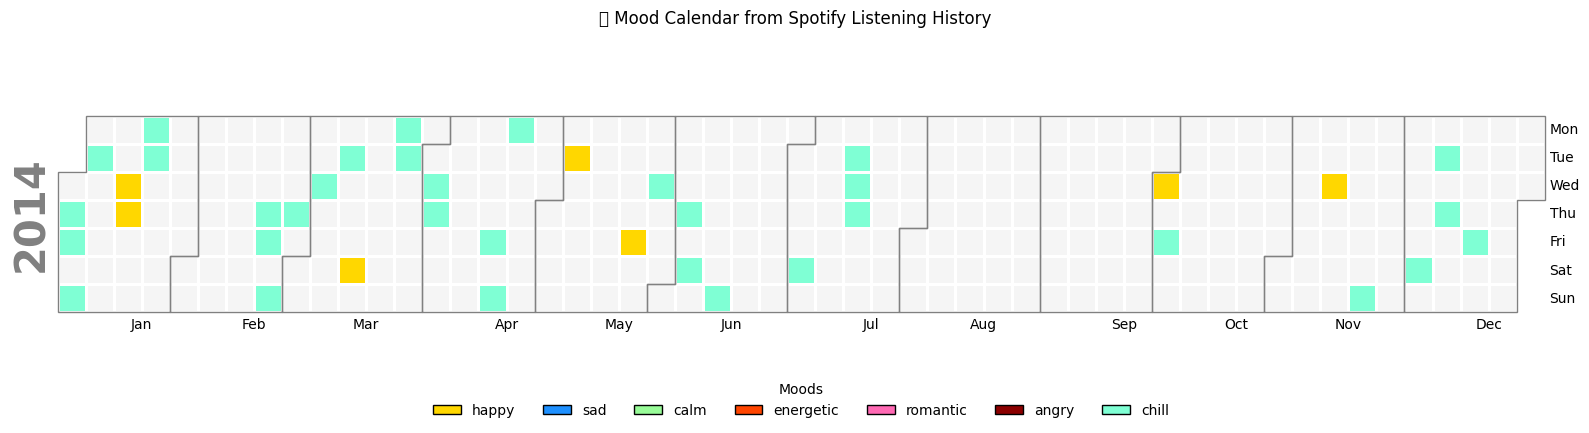

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import calplot
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np
import pandas as pd

# Define your unique moods and assign colors
mood_palette = {
    'happy': '#FFD700',        # gold
    'sad': '#1E90FF',          # dodger blue
    'calm': '#98FB98',         # pale green
    'energetic': '#FF4500',    # orange red
    'romantic': '#FF69B4',     # hot pink
    'angry': '#8B0000',        # dark red
    'chill': '#7FFFD4',        # aquamarine
}

# Convert moods to numeric values for plotting
mood_to_num = {mood: i for i, mood in enumerate(mood_palette.keys())}
num_to_mood = {i: mood for mood, i in mood_to_num.items()}

df_merged['mood_num'] = df_merged['mood'].map(mood_to_num)

# Safely get the dominant mood for each day
def safe_mode(series):
    counts = series.value_counts()
    return counts.idxmax() if not counts.empty else np.nan

mood_values = df_merged.groupby(df_merged['ts'].dt.date)['mood_num'].agg(safe_mode)
mood_values.dropna(inplace=True)
mood_values.index = pd.to_datetime(mood_values.index)

# Custom colormap
custom_cmap = ListedColormap(list(mood_palette.values()))

# Plot the calendar heatmap
fig, ax = calplot.calplot(
    mood_values,
    cmap=custom_cmap,
    figsize=(16, 4),
    colorbar=False,
    suptitle="🎧 Mood Calendar from Spotify Listening History"
)

# Add a custom legend
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in mood_palette.items()
]
plt.legend(
    handles=legend_elements,
    title="Moods",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=len(mood_palette),
    frameon=False
)

plt.tight_layout()
plt.show()
